In [39]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

import json

from geopy.geocoders import Nominatim
from geopy.distance import great_circle

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import ssl


# Collecting Data

## From Wikipedia

In [2]:
# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

url = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
html = urllib.request.urlopen(url, context=ctx).read()
soup = BeautifulSoup(html, 'html.parser')


### Scraping for Neighborhoods, Boroughs, and Postal

In [3]:
import re 
  
def remove(list): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list

my_table = soup.find('table',{'class':'wikitable sortable'})
my_table_body = my_table.findAll('tr')
postal = []
borough = []
neighborhood = []
for row in my_table_body[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    postal.append(cols[3])
    neighborhood.append(cols[0])
    borough.append(cols[1])
                
borough = remove(borough)
for i in range(0,len(borough)):
    borough[i] = borough[i].replace('[','').replace(']','')
    borough[i] = borough[i].strip()
    if ',' in borough[i]:
        borough[i] = borough[i][0:borough[i].index(',')]


## Collection of Population Data

In [4]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

url = "https://www.citypopulation.de/en/uk/greaterlondon/"
html = urllib.request.urlopen(url, context=ctx).read()
soup = BeautifulSoup(html, 'html.parser')


### Cleaning of borough list

In [5]:
list_borough_wiki = list(set(borough))
list_borough_pop = []
list_population = []
my_table = soup.find('table',{'class':'data'},{'class':'rname'})
my_table_body = my_table.findAll('tr')
for row in my_table_body[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    list_borough_pop.append(cols[0])
    list_population.append(cols[6])
    
list_borough_pop = list_borough_pop[:-1]
list_population = list_population[:-1]

dirty_place = []
for place in list_borough_wiki:
    if place in list_borough_pop:
        continue
    else:
        dirty_place.append(place)



In [6]:
for i in range(0,len(borough)):
    if borough[i] == 'Camden and Islington':
        borough[i] = 'Camden'
    elif borough[i] == 'Westminster':
        borough[i] = 'City of Westminster'
    elif borough[i] == 'City':
        borough[i] = 'City of London'
    elif borough[i] == 'Haringey and Barnet':
        borough[i] = 'Haringey'
    elif borough[i] == 'Islington & City':
        borough[i] = 'Islington'
    elif borough[i] == 'Kensington and ChelseaHammersmith and Fulham':
        borough[i] = 'Kensington and Chelsea'


## Creating of DataFrame

In [147]:
london_data = pd.DataFrame()
london_data['Borough'] = borough
london_data['Neighborhood'] = neighborhood
london_data['Postal'] = postal
#-------------------------------------------------------
london_pop = pd.DataFrame()
london_pop['Borough'] = list_borough_pop
london_pop['Population'] = list_population
london_pop
london_data.shape

(533, 3)

# Collection of Latitudes and Longitudes

In [8]:
for i in range(0,len(london_data['Neighborhood'])):
               
    if '(' in london_data['Neighborhood'].iloc[i]:
        
        neigh = london_data['Neighborhood'].iloc[i]
        london_data['Neighborhood'].iloc[i] = neigh[:neigh.index('(')] 

In [9]:
latitudes = []
longitudes = []
count = 0

In [10]:
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderUnavailable

geopy = Nominatim(user_agent="four_square")

def do_geocode(address):
    print(address)
    try:
        return geopy.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)
    except GeocoderUnavailable:
        return do_geocode(address)
    
for place in london_data['Neighborhood'].iloc[count:]:

    address = place+',London'
    location = do_geocode(address)
    if place == 'Sanderstead':
        lat = 51.3342
        long = - 0.0754
    else:
        
        if location == None:
            lat = 'NaN'
            long = 'NaN'
        else:
            lat = location.latitude
            long = location.longitude
    count = count + 1        
    latitudes.append(lat)
    longitudes.append(long)
    
  

Abbey Wood,London
Acton,London
Addington,London
Addiscombe,London
Albany Park,London
Aldborough Hatch,London
Aldgate,London
Aldwych,London
Alperton,London
Alperton,London
Anerley,London
Angel,London
Aperfield,London
Archway,London
Ardleigh Green,London
Arkley,London
Arnos Grove,London
Balham,London
Bankside,London
Barbican,London
Barking,London
Barkingside,London
Barnehurst,London
Barnes,London
Barnes Cray,London
Barnet Gate,London
Barnet ,London
Barnsbury,London
Battersea,London
Bayswater,London
Beckenham,London
Beckton,London
Becontree,London
Becontree Heath,London
Beddington,London
Bedford Park,London
Belgravia,London
Bellingham,London
Belmont,London
Belmont,London
Belsize Park,London
Belvedere,London
Bermondsey,London
Berrylands,London
Bethnal Green,London
Bexley ,London
Bexleyheath ,London
Bickley,London
Biggin Hill,London
Blackfen,London
Blackfriars,London
Blackheath,London
Blackheath Royal Standard,London
Blackwall,London
Blendon,London
Bloomsbury,London
Botany Bay,London
Bounds

Strawberry Hill,London
Streatham,London
Stroud Green,London
Sudbury,London
Sundridge,London
Surbiton,London
Surrey Quays,London
Sutton,London
Swiss Cottage,London
Sydenham ,London
Sydenham Hill,London
Teddington,London
Temple,London
Temple Fortune,London
Thamesmead,London
Thornton Heath,London
Tokyngton,London
Tolworth,London
Tooting,London
Tooting Bec,London
Tottenham,London
Tottenham Green,London
Tottenham Hale,London
Totteridge,London
Tower Hill,London
Tufnell Park,London
Tulse Hill,London
Turnpike Lane,London
Twickenham,London
Upminster,London
Upminster Bridge,London
Upminster Bridge,London
Upminster Bridge,London
Upminster Bridge,London
Upminster Bridge,London
Upper Clapton,London
Upper Holloway,London
Upper Norwood,London
Upper Norwood,London
Upper Norwood,London
Upper Ruxley,London
Upper Walthamstow,London
Upton,London
Upton Park,London
Uxbridge,London
Vauxhall,London
Waddon,London
Wallington,London
Walthamstow,London
Walthamstow Village,London
Walworth,London
Wandsworth,London


In [11]:
london_data['Latitude'] = latitudes
london_data['Longitude'] = longitudes
london_data['Latitude'].iloc[5],london_data['Latitude'].iloc[166],london_data['Latitude'].iloc[411] = [51.5855,51.6654,51.5310]
london_data['Longitude'].iloc[5],london_data['Longitude'].iloc[166],london_data['Longitude'].iloc[411]= [0.0988,-0.0450,-0.1304]
london_data['Latitude'].iloc[78],london_data['Latitude'].iloc[151],london_data['Latitude'].iloc[422] = [51.8064,51.4689,51.5459]
london_data['Longitude'].iloc[78],london_data['Longitude'].iloc[151],london_data['Latitude'].iloc[422] = [1.1393,0.1017,0.7077]

# Mapping of London

In [12]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_london = location.latitude
longitude_london = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude_london, longitude_london))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [13]:
# create map of New York using latitude and longitude values
map_london= folium.Map(location=[latitude_london, longitude_london], zoom_start = 10)

# add markers to map
for lat, lng, borough, neighborhood in zip(london_data['Latitude'], london_data['Longitude'], london_data['Borough'], london_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london


## Analysis of Westminster

In [14]:
westminster_data = london_data[london_data['Borough'] == 'City of Westminster'].reset_index(drop=True)
#westminster_data

## Mapping of Westminster

In [15]:
# create map of Manhattan using latitude and longitude values

map_westminster = folium.Map(location=[latitude_london, longitude_london], zoom_start=11)

# add markers to map
for lat, lng, label in zip(westminster_data['Latitude'], westminster_data['Longitude'], westminster_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_westminster)  
    
map_westminster

## Analysis of other Boroughs 

In [16]:
#We will find the top 5 largest boroughs for our next analysis

In [65]:
top_five = london_pop.sort_values(by = ['Population'],ascending = False)[1:6]

for num, i in zip(top_five['Population'],range(0,5)):
    top_five['Population'].iloc[i] = num.replace(',','')
top_five['Population'] = pd.to_numeric(top_five['Population'])

In [66]:
top1_data = london_data[london_data['Borough'] == 'Barnet'].reset_index()

In [67]:
top2_data = london_data[london_data['Borough'] == 'Croydon'].reset_index()

In [68]:
top3_data = london_data[london_data['Borough'] == 'Newham'].reset_index()

In [69]:
top4_data = london_data[london_data['Borough'] == 'Ealing'].reset_index()

In [70]:
top5_data = london_data[london_data['Borough'] == 'Enfield'].reset_index()

([], <a list of 0 Text yticklabel objects>)

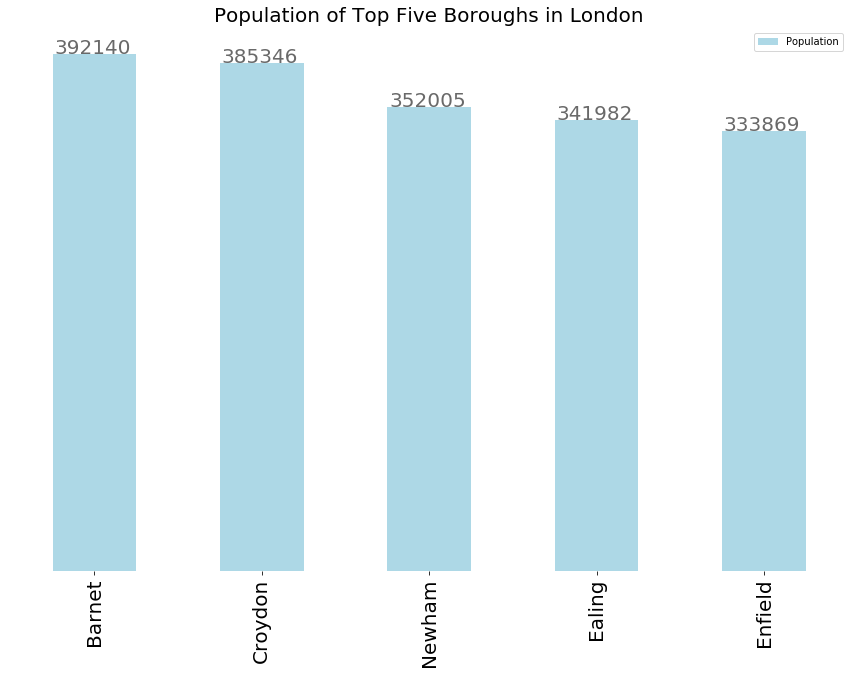

In [113]:
import matplotlib.pyplot as plt

ax = top_five.set_index('Borough').plot(kind = 'bar',figsize = (15,10), color = '#add8e6', fontsize = 20)
ax.set_title(label="Population of Top Five Boroughs in London",fontsize = 20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

total = []
for i in ax.patches:
    total.append(i.get_height())
    
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.01, i.get_height()+1,str(i.get_height()), fontsize=20,color='dimgrey')

ax.set_xlabel(xlabel = '')
plt.yticks([])

# FourSqaure

In [23]:
CLIENT_ID = 'YNVDZFGUVDBLQZAQD3ZM5QYZTP0G5BRTSCY4DX4RBSGHCZCL' # your Foursquare ID
CLIENT_SECRET = 'PUPENX4AXDYWJ2BFCRUQSTLV43AVNFXZP2B22JBRDGFPHE4M' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

## Function to ge the nearby Food Outlets in a Borough

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
  
        # create the API request URL
        food_category = '4d4b7105d754a06374d81259'
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            food_category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Getting the nearby food outlets for the top 5 boroughs

In [25]:
#['bromley', 'barnet', 'ealing', 'croydon', 'enfield']
top1_venues = getNearbyVenues(names=top1_data['Neighborhood'],
                                   latitudes=top1_data['Latitude'],
                                   longitudes=top1_data['Longitude'])
top2_venues = getNearbyVenues(names=top2_data['Neighborhood'],
                                   latitudes=top2_data['Latitude'],
                                   longitudes=top2_data['Longitude'])
top3_venues = getNearbyVenues(names=top3_data['Neighborhood'],
                                   latitudes=top3_data['Latitude'],
                                   longitudes=top3_data['Longitude'])
top4_venues = getNearbyVenues(names=top4_data['Neighborhood'],
                                   latitudes=top4_data['Latitude'],
                                   longitudes=top4_data['Longitude'])
top5_venues = getNearbyVenues(names=top5_data['Neighborhood'],
                                   latitudes=top5_data['Latitude'],
                                   longitudes=top5_data['Longitude'])


## Function to find the frequency of the types of food outlets in a borough

In [26]:
#finding how may of each type of restaurant are there in Westminster
def count_venues(borough):
    venue_freq = pd.DataFrame()
    venues = []
    count = []
    for group,frame in borough.groupby('Venue Category'):
        venues.append(group)
        count.append(frame['Venue'].count())



    venue_freq['Venues'] = venues
    venue_freq['Count'] = count
    return venue_freq


In [27]:
top1_count = count_venues(top1_venues).sort_values(by=['Count'],ascending = False)
top1_count.head()

,Venues,Count
10,Café,55
17,Fast Food Restaurant,32
25,Indian Restaurant,21
11,Chinese Restaurant,19
27,Italian Restaurant,18


In [28]:
top2_count = count_venues(top2_venues).sort_values(by=['Count'],ascending = False)
top2_count.head()

,Venues,Count
16,Indian Restaurant,16
6,Café,15
13,Fast Food Restaurant,11
22,Pizza Place,10
17,Italian Restaurant,8


In [29]:
top3_count = count_venues(top3_venues).sort_values(by=['Count'],ascending = False)
top3_count.head()

,Venues,Count
10,Café,22
6,Bakery,11
45,Sandwich Place,11
30,Indian Restaurant,11
20,Fast Food Restaurant,10


In [30]:
top4_count = count_venues(top4_venues).sort_values(by=['Count'],ascending = False)
top4_count.head()

,Venues,Count
7,Café,18
22,Indian Restaurant,15
15,Fast Food Restaurant,8
3,Bakery,7
32,Pizza Place,7


In [31]:
top5_count = count_venues(top5_venues).sort_values(by=['Count'],ascending = False)
top5_count.head()

,Venues,Count
6,Café,16
28,Turkish Restaurant,9
12,Fish & Chips Shop,7
16,Indian Restaurant,6
1,Bakery,6


### Merging of the data of the top 5 boroughs

In [32]:
result = pd.merge(top1_count,top2_count,left_on = 'Venues',right_on = 'Venues')
result = pd.merge(result,top3_count,left_on = 'Venues',right_on = 'Venues')
result = pd.merge(result,top4_count,left_on = 'Venues',right_on = 'Venues')
result = pd.merge(result,top5_count,left_on = 'Venues',right_on = 'Venues')
result

,Venues,Count_x,Count_y,Count_x,Count_y,Count
0,Café,55,15,22,18,16
1,Fast Food Restaurant,32,11,10,8,2
2,Indian Restaurant,21,16,11,15,6
3,Chinese Restaurant,19,8,4,6,5
4,Italian Restaurant,18,8,4,4,5
5,Pizza Place,16,10,9,7,4
6,Bakery,15,5,11,7,6
7,Turkish Restaurant,13,1,5,2,9
8,Sandwich Place,10,6,11,5,4
9,Fish & Chips Shop,7,4,5,1,7


In [33]:
result.columns = ['Venues','Barnet','Croydon','Newham','Ealing','Enfield']

In [34]:
total = result.sum(axis = 1)
result['Total'] = total

In [35]:
result

,Venues,Barnet,Croydon,Newham,Ealing,Enfield,Total
0,Café,55,15,22,18,16,126
1,Fast Food Restaurant,32,11,10,8,2,63
2,Indian Restaurant,21,16,11,15,6,69
3,Chinese Restaurant,19,8,4,6,5,42
4,Italian Restaurant,18,8,4,4,5,39
5,Pizza Place,16,10,9,7,4,46
6,Bakery,15,5,11,7,6,44
7,Turkish Restaurant,13,1,5,2,9,30
8,Sandwich Place,10,6,11,5,4,36
9,Fish & Chips Shop,7,4,5,1,7,24


#### Where to open what?
Now I want to open an Indian Restaurant so where should I open it? I want to open it in a populated area, but not where there is too much competition, thus I would choose one of the Top5 populated boroughs. Using the above table it can be concluded that the borough 'Enfield' has the least number of Indian Restaurants, thus being the safest choice.

Now I am going to find the mean location of the restaurants and then all the locations at a radius of 5 km from that location to give me the list of the suitable locations

In [114]:
indian_restaurants = top5_venues[top5_venues['Venue Category'] == 'Indian Restaurant']
indian_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Arnos Grove,51.616402,-0.133287,New Curry Garden,51.616095,-0.134448,Indian Restaurant
28,Enfield Lock,51.670887,-0.028573,Albany Tandoori,51.669074,-0.034617,Indian Restaurant
38,Enfield Town,51.651716,-0.078684,Enfield Tandoori,51.651793,-0.080651,Indian Restaurant
52,Enfield Wash,51.665400,-0.045000,Mehek,51.664038,-0.044806,Indian Restaurant
68,Palmers Green,51.622254,-0.112738,Dipali Indian Restaurant,51.619402,-0.113847,Indian Restaurant
71,Palmers Green,51.622254,-0.112738,"Taste of Raj, Palmers Green",51.619092,-0.113581,Indian Restaurant


In [142]:
address = 'Enfield, London'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_enfield = location.latitude
longitude_enfield = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude_enfield, longitude_enfield))

The geograpical coordinate of London are 51.6520851, -0.0810175.


In [143]:
# create map of Enfield using latitude and longitude values

map_enfield = folium.Map(location=[latitude_enfield, longitude_enfield], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(indian_restaurants['Neighborhood Latitude'],indian_restaurants['Neighborhood Longitude'], indian_restaurants['Neighborhood']):
    label = '{}, {}'.format(neighborhood, "Enfield")
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_enfield)  
    
map_enfield

In [117]:
mean_latitude = indian_restaurants['Neighborhood Latitude'].values.mean()
mean_longitude = indian_restaurants['Neighborhood Longitude'].values.mean()


In [134]:
nearby_neighborhoods = []
for lat, long, place in zip(top5_data['Latitude'],top5_data['Longitude'],top5_data['Neighborhood']):
    if great_circle((lat,long),(mean_latitude,mean_longitude)) <= 5:
            nearby_neighborhoods.append(place)
        

In [137]:
for place in indian_restaurants['Neighborhood']:
    if place in nearby_neighborhoods:
        nearby_neighborhoods.remove(place)

In [138]:
print("               List of potential locations                ")
print("----------------------------------------------------------")
for place in nearby_neighborhoods:
    print(place+',London')
    

               List of potential locations                
----------------------------------------------------------
Botany Bay,London
Brimsdown,London
Bulls Cross,London
Edmonton,London
Enfield Highway,London
Freezywater,London
Ponders End,London
Southgate,London
Winchmore Hill,London


In [139]:
data = []
for place, lat, long in zip(top5_data['Neighborhood'], top5_data['Latitude'],top5_data['Longitude']):
    if place in nearby_neighborhoods:
        data.append((place,lat,long))
        
potentials = pd.DataFrame(data, columns = ['Neighborhood','Latitude','Longitude'])
potentials

,Neighborhood,Latitude,Longitude
0,Botany Bay,51.676581,-0.125903
1,Brimsdown,51.655571,-0.030838
2,Bulls Cross,51.678410,-0.059074
3,Edmonton,51.620339,-0.065979
4,Enfield Highway,51.657021,-0.047100
5,Freezywater,51.673977,-0.039899
6,Ponders End,51.643035,-0.034693
7,Southgate,51.628155,-0.123596
8,Winchmore Hill,51.633941,-0.101003


In [145]:
# create map of Enfield using latitude and longitude values

map_potentials = folium.Map(location=[latitude_enfield, longitude_enfield], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(potentials['Latitude'],potentials['Longitude'], potentials['Neighborhood']):
    label = '{}, {}'.format(neighborhood, "Enfield")
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_potentials)  
    
map_potentials